# Ohsome API analysis Notebook

This notebook has been developped to test the interaction with the Ohsome API. It serves as a sandbox before implementing indicators and layers to the OQT project.  

It contains a simple query to retrieve aggregated results for a given layer and country.

We also added some steps to retrieve layers geometries and to compute global thresholds for some indicators based on percentile of global distribution.


- link to OQT project GIT repo : https://github.com/GIScience/ohsome-quality-analyst
- link to Ohsome API doc : https://docs.ohsome.org/ohsome-api/stable/endpoints.html


## 1) Import Packages

In [1]:
from math import *
import numpy as np
import seaborn as sns
import requests
import time

import json
import pandas as pd
import geopandas as gpd
from geojson import Feature, FeatureCollection, Point



## 2) Setup

- Aggregation funcitons used here are simply the endpoins of the API
- Filters correspond to the 6 layers defined on the Map Action Report for OQT
- Function query_api() is used to simplify access to the API for a given layer, aggregation and country. It uses geopandas naturalearth_lowres dataset for country borders

In [2]:


agg_count = 'https://api.ohsome.org/v1/elements/count'
agg_length = 'https://api.ohsome.org/v1/elements/length'
agg_area = 'https://api.ohsome.org/v1/elements/area'

agg_count_density = 'https://api.ohsome.org/v1/elements/count/density'
agg_count_ratio = 'https://api.ohsome.org/v1/elements/count/ratio'
agg_geometry = 'https://api.ohsome.org/v1/elements/geometry'

#---------------------------------

filter_capital_city = "place=city and (is_capital=country or admin_level=2 or capital=yes) and type:node"
filter_settlements = "place=city and type:node"
filter_major_roads = "highway in (motorway, trunk, primary) and (type:way or type:relation)"
filter_rail = "railway=rail and (type:way or type:relation)"
filter_lakes = "(water in (lagoon,lake,reservoir) or landuse = reservoir) and (type:way or type:relation)"
filter_rivers = "waterway in (riverbank,river) and (type:way or type:relation)"


#---------------------------------

In [3]:
def query_api(URL,query_filter,country_code,query_time = "2021-01-01"):
    
    #some countries have an invalide (-99) country_code. We could improve this function by replacing the 
    #country code by the country name
    if country_code == '-99':
        return(-1)
    
    #retrieve country boundaries and create a GeoJSON file from it
    world_gdf = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
    country_gdf = world_gdf[world_gdf.iso_a3 == country_code]
    geojson_file =  json.loads(country_gdf.to_json())

    #obtain a polygon from the GeoJSON file. In theory the API bpolys accepts GeoJSON files as input
    #but I could not make it work.
    if geojson_file['features'][0]['geometry']['type'] == 'MultiPolygon':
        country_poly = ''
        for new_poly in geojson_file['features'][0]['geometry']['coordinates']:
            country_poly = country_poly + '|' + str(new_poly[0])
        country_poly = country_poly.replace('[','').replace(']','') 
        country_poly = country_poly[1:]
    else:
        country_poly = str(geojson_file['features'][0]['geometry']['coordinates']).replace('[','').replace(']','')
    
    #small difference between aggregation functions and geometries, the latter doesn't have a "format" variable.
    if URL == 'https://api.ohsome.org/v1/elements/geometry':    
        data = {"bpolys": country_poly, "time": query_time, "filter": query_filter}
    else:   
        data = {"bpolys": country_poly, "format": "json", "time": query_time, "filter": query_filter}
           
    response = requests.post(URL, data=data)
    
    #handles void results and return result depending on url type
    if str(response) == '<Response [404]>':
        return(-1)
    elif URL == 'https://api.ohsome.org/v1/elements/geometry':
        return(response.json())
    else:     
        return(response.json()['result'][0]['value'])

## 3) Execute query

Single query for a given aggregation (URL), layer (filter) and country. Query time can also be changed. Default value is set to 01/01/2021 but we can have more recent or older data.

5 countries on the present scope : 

- Bangladesh (BGD)
- South Sudan (SSD)
- Myanmar (MMR)
- Dominican Republic (DOM)
- Haiti (HTI)







In [4]:
query_api(URL = agg_length,query_filter = filter_rail,country_code = 'SSD')

260887.71

## 4) Export geometry

Use this small code to retrieve geometries for all the layers and all the five countries. This query can take some time depending on the number of countries and the size of the layers. GeoJSON files are stored locally.

In [ ]:

layer_dict = {}
layer_dict['settlements'] = filter_settlements
layer_dict['major_roads'] = filter_major_roads
layer_dict['rail'] = filter_rail
layer_dict['lakes'] = filter_lakes
layer_dict['rivers'] = filter_rivers

folder_name = './osm_output/'


for country_code in ('BGD','SSD','MMR','DOM','HTI'):

    for layer in ('settlements','major_roads','rail','lakes','rivers'):
        print(layer)
        query_filter = layer_dict[layer]
        output_geo = query_api(URL = agg_geometry,query_filter = query_filter,country_code = country_code)

        filename =  folder_name + country_code.lower() + '_' + layer + '.geojson'

        with open(filename, 'w', encoding='utf-8') as f:
            json.dump(output_geo, f, ensure_ascii=False)
            
        print(filename)

## 5) Threshold Computation

We compute here statistics for two layers (major roads and settlements) for all the countries available. We then use density percentiles as thresholds for indicators quality.

For example, if a country settlements density (unit per million habitants) or road density (km per million habitants) lies below the 5% world-wide percentile we say it has a low quality for this indicator. Between 5% and 20% is medium and over 20% is high.

This is a very simple approch that should be improved in the future

### 5.1) Load data

In [ ]:
world_gdf = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
new_df = world_gdf.copy()
# computing the area without taking projection in account is not very smart but should be enough for
#a preliminary correlation analysis.
new_df['country_area'] = new_df.geometry.area

In [ ]:
# compute settlements count for all the countries. This may take around 5 minutes for 177 countries.

t0 = time.time()

N_countries = world_gdf.shape[0]
i = 0
new_df['sett_count'] = 0


for country_code in list(new_df.iso_a3.values):
    i = i + 1
    print(str(i) + '/' + str(N_countries) + ' - ' + country_code)
    new_df.loc[new_df.iso_a3 == country_code,'sett_count'] = query_api(agg_count,filter_settlements,country_code)
        
print((time.time() - t0)/60)

In [ ]:
# compute road length for all the countries. This may take around 30 minutes for 177 countries.


t0 = time.time()

N_countries = world_gdf.shape[0]
i = 0
new_df['road_length'] = 0


for country_code in list(new_df.iso_a3.values):
    i = i + 1
    print(str(i) + '/' + str(N_countries) + ' - ' + country_code)
    new_df.loc[new_df.iso_a3 == country_code,'road_length'] = query_api(agg_length,filter_major_roads,country_code)
        
print((time.time() - t0)/60)


In [5]:
#possible to save statistics per country on a file to avoid re-running the above queries every time
#new_df.to_csv('./osm_output/threshold_analysis.csv', index = False)
#new_df = pd.read_csv('./osm_output/threshold_analysis.csv')

### 5.2) Compute thresholds

In [6]:
# compute densities and drop countries with no settlements

new_df['road_per_pop'] = new_df['road_length']/new_df['pop_est']*1e3
new_df['sett_per_pop'] = new_df['sett_count']/new_df['pop_est']*1e6

df = new_df[new_df.sett_count > 0].copy()

In [7]:
# correlation showing that settlements and road are more related to population than size

df[['pop_est','country_area','sett_count','road_length']].corr(method = 'spearman')

,pop_est,country_area,sett_count,road_length
pop_est,1.000000,0.659239,0.795760,0.798376
country_area,0.659239,1.000000,0.646752,0.751038
sett_count,0.795760,0.646752,1.000000,0.807804
road_length,0.798376,0.751038,0.807804,1.000000


In [8]:

print(df.sett_per_pop.quantile(0.05))
print(df.sett_per_pop.quantile(0.2))

print(df.road_per_pop.quantile(0.05))
print(df.road_per_pop.quantile(0.2))

0.30439759079042056
0.6533646256776091
146.12205125465917
295.7190506317715


#### Settlements per million habitants
- 5% : 0.30
- 20% : 0.65

#### Road km per million habitants
- 5% : 146
- 20% : 296

In [9]:
# set quality thresholds based on percentiles

df['set_tag'] = 'good'
df.loc[df.sett_per_pop < 0.65, 'set_tag'] = 'medium'
df.loc[df.sett_per_pop < 0.3, 'set_tag'] = 'bad'

df['road_tag'] = 'good'
df.loc[df.road_per_pop < 296, 'road_tag'] = 'medium'
df.loc[df.road_per_pop < 146, 'road_tag'] = 'bad'

Text(0.5, 1.0, 'Settlements vs Population')

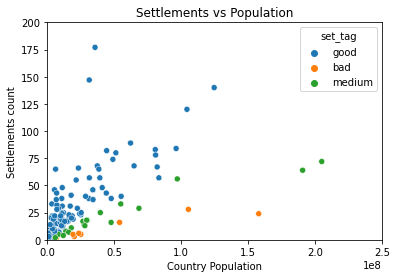

In [10]:

ax = sns.scatterplot(x = df.pop_est, y = df.sett_count, hue = df.set_tag)
ax.set_xlim([0,2.5e8])
ax.set_ylim([0,200])
ax.set_xlabel('Country Population')
ax.set_ylabel('Settlements count')
ax.set_title('Settlements vs Population')

Text(0.5, 1.0, 'Roads vs Population')

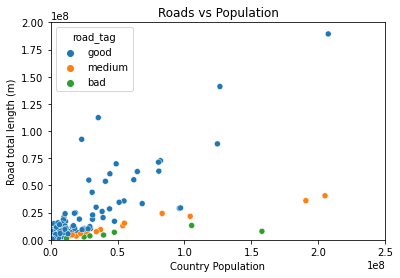

In [11]:

ax = sns.scatterplot(x = df.pop_est, y = df.road_length, hue = df.road_tag)
ax.set_xlim([0,2.5e8])
ax.set_ylim([0,2e8])
ax.set_xlabel('Country Population')
ax.set_ylabel('Road total length (m)')
ax.set_title('Roads vs Population')

In [12]:
# the quality for our 5 countries

df[df.iso_a3.isin(['BGD','SSD','MMR','DOM','HTI'])] 


,pop_est,continent,name,iso_a3,gdp_md_est,geometry,country_area,road_length,road_per_pop,sett_count,sett_per_pop,set_tag,road_tag
16,10646714,North America,Haiti,HTI,19340.0,POLYGON ((-71.71236141629296 19.71445587816736...,2.447114,913119.60,85.765392,20,1.878514,good,bad
17,10734247,North America,Dominican Rep.,DOM,161900.0,POLYGON ((-71.70830481635805 18.04499705654609...,4.129206,3177262.38,295.993038,25,2.328994,good,medium
93,55123814,Asia,Myanmar,MMR,311100.0,"POLYGON ((100.1159875834178 20.41784963630819,...",59.157493,15326021.64,278.029050,40,0.725639,good,medium
99,157826578,Asia,Bangladesh,BGD,628400.0,"POLYGON ((92.67272098182556 22.04123891854125,...",11.857175,7789558.06,49.355173,24,0.152066,bad,bad
176,13026129,Africa,S. Sudan,SSD,20880.0,"POLYGON ((30.83385242171543 3.509171604222463,...",51.196106,5482992.84,420.922658,17,1.305069,good,good


## 6) Annexe

In [ ]:
#with open('./my_file.geojson', 'w', encoding='utf-8') as f:
#    json.dump(geojson_file, f, ensure_ascii=False)

In [ ]:
country_code = 'BGD'

world_gdf = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
country_gdf = world_gdf[world_gdf.iso_a3 == country_code]
geojson_file =  json.loads(country_gdf.to_json())
#geojson_file = "Region 1:8.65821,49.41129,8.65821,49.41825,8.70053,49.41825,8.70053,49.41129,8.65821,49.41129|Region 2:8.67817,49.42147,8.67817,49.4342,8.70053,49.4342,8.70053,49.42147,8.67817,49.42147"
#country_poly = str(country_gdf.geometry.values[0]).replace('POLYGON ((','').replace('))','').replace(', ',',').replace(' ',',')
#geojson_file = "8.65821,49.41129,8.65821,49.41825,8.70053,49.41825,8.70053,49.41129,8.65821,49.41129|8.67817,49.42147,8.67817,49.4342,8.70053,49.4342,8.70053,49.42147,8.67817,49.42147"


#data = {"bpolys": geojson_file, "format": "json", "time": query_time, "filter": query_filter}
#response = requests.post(URL, data=data)
